<a href="https://colab.research.google.com/github/muxair080/plant_disease_detection_streamlit_app/blob/main/peeper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Peeper Disease Classification

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
!kaggle datasets download -d arjuntejaswi/plant-village

 94% 309M/329M [00:03<00:00, 111MB/s]
100% 329M/329M [00:03<00:00, 104MB/s]


**Extract datasete folder**
Dowloaded dataset is in .zip format so the bellow code will extract the code in the given folder.

In [5]:
import zipfile
zip_ref = zipfile.ZipFile('/content/plant-village.zip')
zip_ref.extractall('/content')
zip_ref.close()

In the downloaded dataset has some more plants images also the bellow code is deleting extra folders from the dataset directory.

In [7]:
import os
import shutil

# Set the path to the dataset directory
dataset_dir = "/content/PlantVillage"

# List all directories in the dataset
directories = [f for f in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, f))]

# Specify the directories you want to delete
directories_to_delete = ["Tomato_Bacterial_spot"
,"Tomato_Early_blight", "Tomato_Late_blight", "Tomato_Leaf_Mold", "Tomato_Septoria_leaf_spot",
                         "Tomato_Spider_mites_Two_spotted_spider_mite","Tomato__Target_Spot",
                         "Tomato__Tomato_YellowLeaf__Curl_Virus",
                         "Tomato__Tomato_mosaic_virus", "Tomato_healthy","Potato___Late_blight",
                         "Potato___Early_blight","Potato___healthy"]

# Iterate over the directories and delete them along with their contents
for directory in directories_to_delete:
    directory_path = os.path.join(dataset_dir, directory)
    if os.path.exists(directory_path):
        shutil.rmtree(directory_path)
        print(f"Deleted directory: {directory_path}")
    else:
        print(f"Directory not found: {directory_path}")


Directory not found: /content/PlantVillage/Tomato_Bacterial_spot
Directory not found: /content/PlantVillage/Tomato_Early_blight
Directory not found: /content/PlantVillage/Tomato_Late_blight
Directory not found: /content/PlantVillage/Tomato_Leaf_Mold
Directory not found: /content/PlantVillage/Tomato_Septoria_leaf_spot
Directory not found: /content/PlantVillage/Tomato_Spider_mites_Two_spotted_spider_mite
Directory not found: /content/PlantVillage/Tomato__Target_Spot
Directory not found: /content/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus
Directory not found: /content/PlantVillage/Tomato__Tomato_mosaic_virus
Directory not found: /content/PlantVillage/Tomato_healthy
Directory not found: /content/PlantVillage/Potato___Late_blight
Deleted directory: /content/PlantVillage/Potato___Early_blight
Deleted directory: /content/PlantVillage/Potato___healthy


### Load Dependencies

In [8]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

### Set all the Constants

In [9]:
BATCH_SIZE=32
IMAGE_SIZE=256
CHANNELS=3
EPOCHS=20

### Import data into tensorflow dataset objest

In [10]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
'PlantVillage',
    seed=123,
    shuffle= True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2475 files belonging to 2 classes.


In [11]:
class_names = dataset.class_names

In [12]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 0 1 0 0 0 1 0 1 1 0 0 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1]


### Visualize some of the images from our dataset

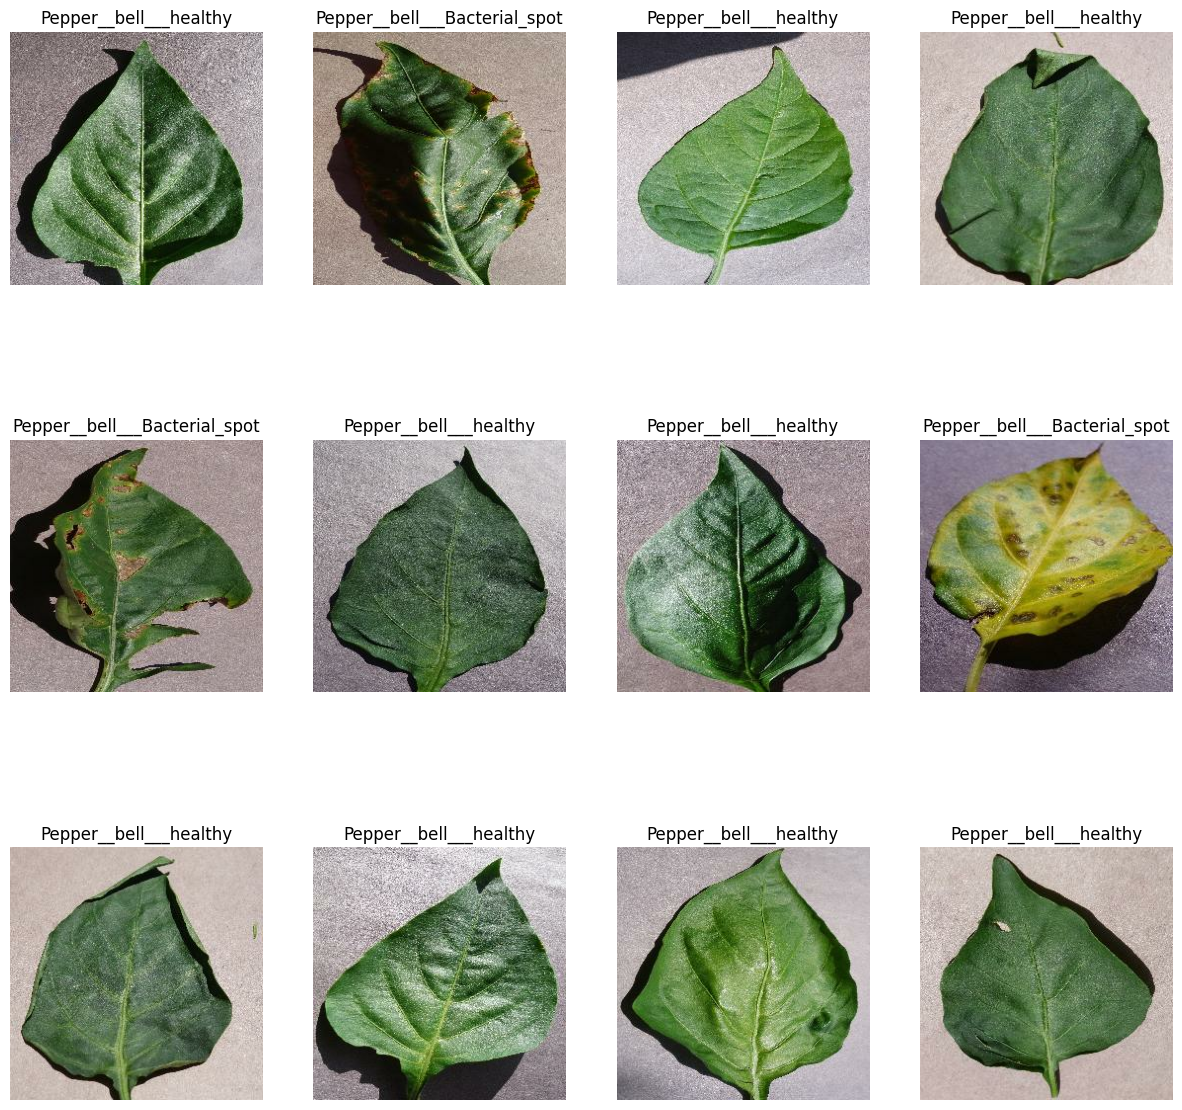

In [14]:
plt.figure(figsize=(15,15))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Function to Split Dataset
Dataset should be divided into 3 subsets, namely
1. Training: Dataset to be used while training.
2. Validataion: Dataset to be tested against while training
3. Test: Datast to be tested against after we trained a model.

In [15]:
len(dataset)

78

In [16]:
train_size=0.8
len(dataset)*train_size

62.400000000000006

In [17]:
test_ds = dataset.skip(54)
len(test_ds)

24

In [ ]:
val_ds = 0.1
len(dataset)*val_ds

6.800000000000001

In [18]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [19]:
test_ds = test_ds.skip(6)
len(test_ds)

18

In [20]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
        ds_size = len(ds)
        if shuffle:
            ds = ds.shuffle(shuffle_size, seed=12)

        train_size = int(train_split *ds_size)
        val_size = int(val_split*ds_size)
        train_ds = ds.take(train_size)
        val_ds = ds.skip(train_size).take(val_size)
        test_ds  = ds.skip(train_size).skip(val_size)

        return train_ds, val_ds, test_ds

In [21]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [22]:
print("training dataset", len(train_ds))
print("Validation dataset", len(val_ds))
print("Test dataset", len(test_ds))

training dataset 62
Validation dataset 7
Test dataset 9


In [23]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building Model

### Create a layer for resizing and Normalizing images

In [24]:
resize_and_recale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255),
])

## Data Augmentation
Create duplate copies of iamges in different rotations and sides to bossts the accuracy of the models.

In [25]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

### Apply Data Augmentation to Train Dataset

In [26]:
train_ds = train_ds.map(
lambda x, y: (data_augmentation(x, training=True),y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

## Model Architecture
We use a CNN Coupled with softmax activation in the output layer. wealso add the inital layers for resizeing and normalizatio and data augmentation.

In [27]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=3
model = models.Sequential([
    resize_and_recale,
    data_augmentation,
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),

    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

# Compiling the Model
We use adam Optimizer SparseCategoricalCrossentropy for losses and accuracy as a metric

In [29]:
model.compile(optimizer='adam',
             loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy']
             )

In [30]:
history = model.fit(
train_ds,
    batch_size= BATCH_SIZE,
    validation_data= val_ds,
    verbose=1,
    epochs=20
)

Epoch 1/20
62/62 [==============================] - 38s 351ms/step - loss: 0.6544 - accuracy: 0.6312 - val_loss: 0.5303 - val_accuracy: 0.7277
Epoch 2/20
62/62 [==============================] - 18s 282ms/step - loss: 0.3760 - accuracy: 0.8640 - val_loss: 0.9647 - val_accuracy: 0.7500
Epoch 3/20
62/62 [==============================] - 18s 283ms/step - loss: 0.2295 - accuracy: 0.9338 - val_loss: 0.5969 - val_accuracy: 0.8482
Epoch 4/20
62/62 [==============================] - 17s 279ms/step - loss: 0.1541 - accuracy: 0.9567 - val_loss: 0.5816 - val_accuracy: 0.8661
Epoch 5/20
62/62 [==============================] - 18s 288ms/step - loss: 0.0793 - accuracy: 0.9796 - val_loss: 0.0925 - val_accuracy: 0.9821
Epoch 6/20
62/62 [==============================] - 17s 281ms/step - loss: 0.0772 - accuracy: 0.9755 - val_loss: 0.1998 - val_accuracy: 0.9821
Epoch 7/20
62/62 [==============================] - 18s 291ms/step - loss: 0.0566 - accuracy: 0.9883 - val_loss: 0.1093 - val_accuracy: 0.9777

In [31]:
scores = model.evaluate(test_ds)

9/9 [==============================] - 3s 30ms/step - loss: 0.0093 - accuracy: 0.9965


In [32]:
scores

[0.009303704835474491, 0.9965277910232544]

## Plotting The Accuracy and Los Curves

In [33]:
history

In [34]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 62}

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

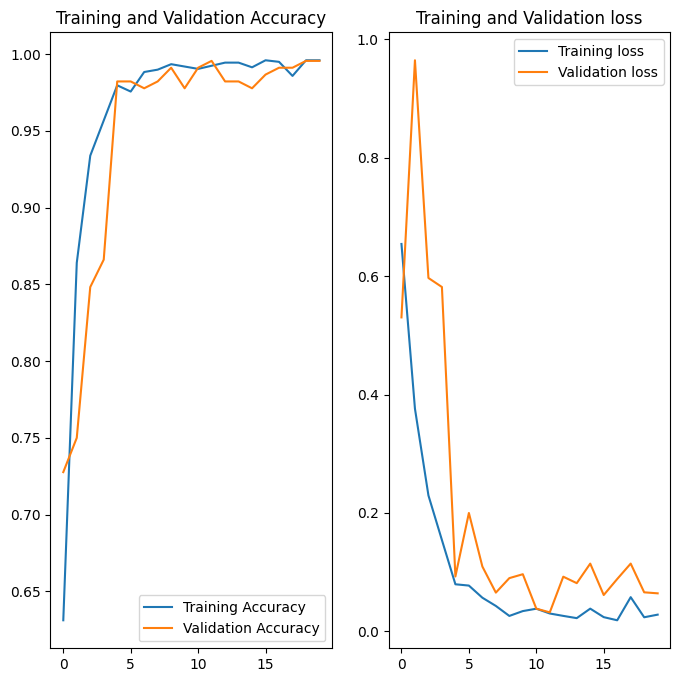

In [36]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training loss')
plt.plot(range(EPOCHS), val_loss, label='Validation loss')
plt.legend(loc='upper right')
plt.title('Training and Validation loss')
plt.show()



# Prediction on a Sample Image

First image to predict
Actual label Pepper__bell___Bacterial_spot
1/1 [==============================] - 0s 151ms/step
Predicted label: Pepper__bell___Bacterial_spot


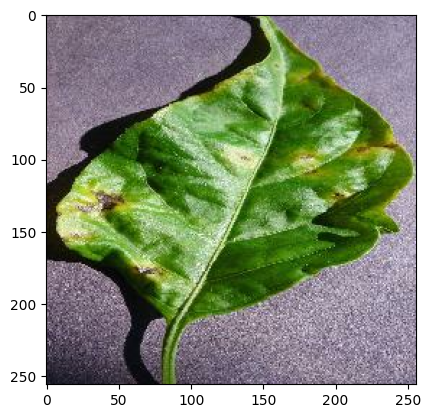

In [37]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    print("First image to predict")
    plt.imshow(first_image)
    print("Actual label", class_names[first_label])
    batch_prediction = model.predict(images_batch)
    print("Predicted label:", class_names[np.argmax(batch_prediction[0])])

### Write a functino for inference

In [38]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

### Now run Inference on few sample images

1/1 [==============================] - 0s 41ms/step


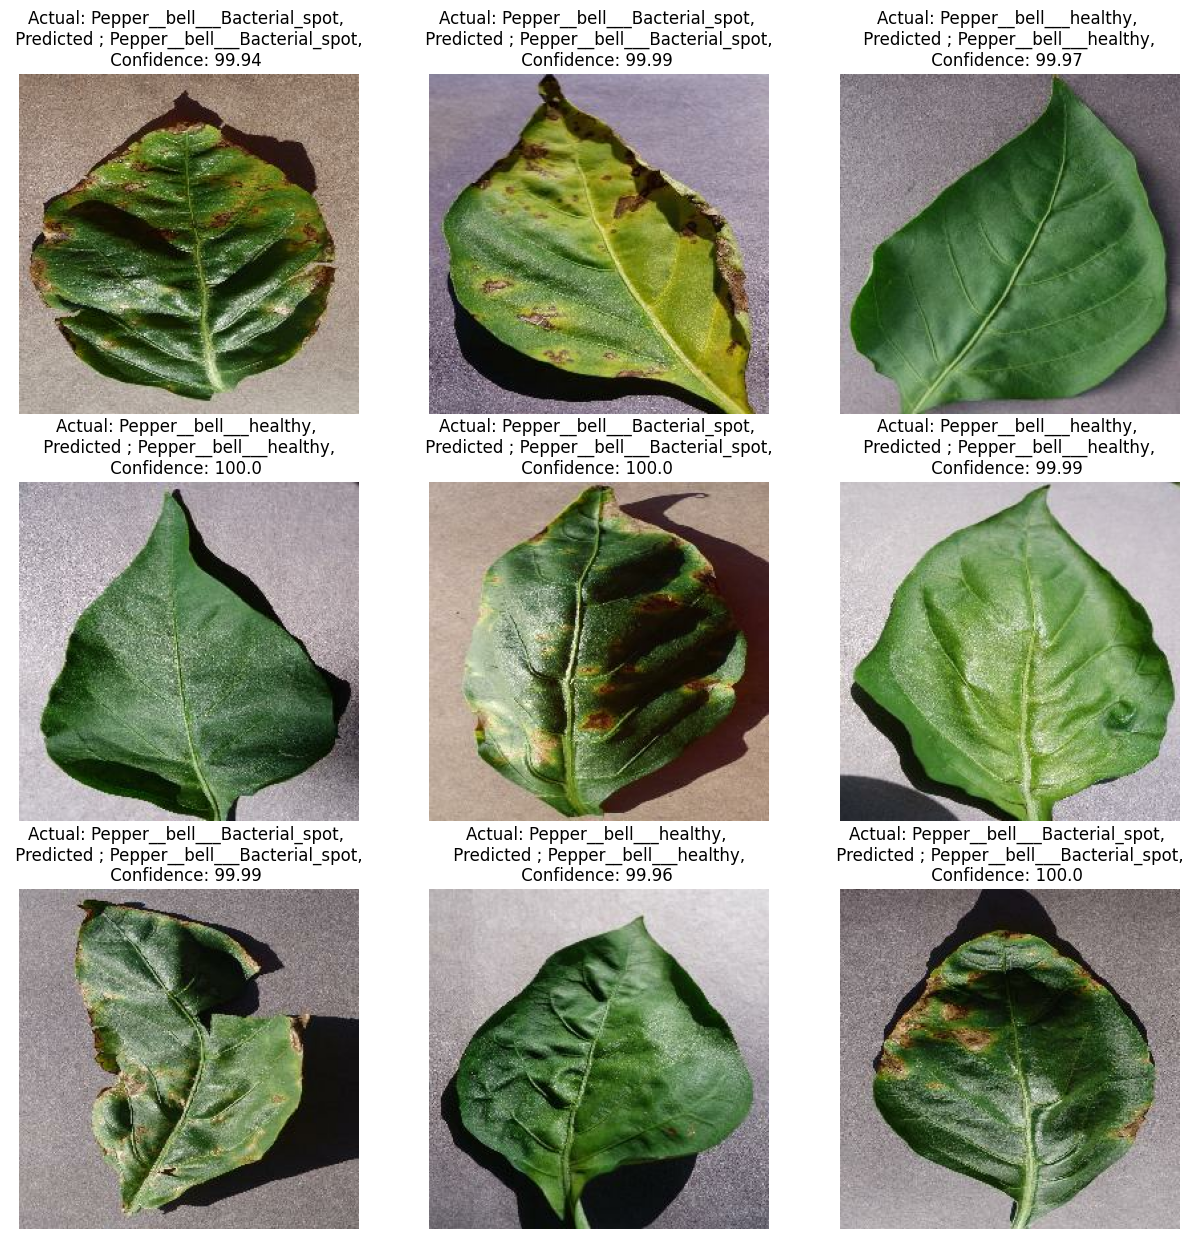

In [39]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        predicted_class , confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f'Actual: {actual_class}, \n Predicted ; {predicted_class}, \n Confidence: {confidence}  ')
        plt.axis('off')

### Saving the Model
Save differenet versions of your models suppose in one version we skip data augmentation, in second version we add data augmentation, in 3rd version we maximize data etc.

In [41]:
import os
model_version = max(int(i) for i in os.listdir('/content/trained_models')+[0])+1
model.save(f'/content/trained_models/{model_version}')

In [42]:
model.save("/content/potatoes.h5")

In [44]:
import os
import zipfile

zf = zipfile.ZipFile("/content/myzipfile.zip", "w")
for dirname, subdirs, files in os.walk("/content/trained_models"):
    zf.write(dirname)
    for filename in files:
        zf.write(os.path.join(dirname, filename))
zf.close()